In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [9]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 7))

In [10]:
rand_sub_bval_indice_100206

array([ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271])

In [11]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [12]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [13]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [14]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [15]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

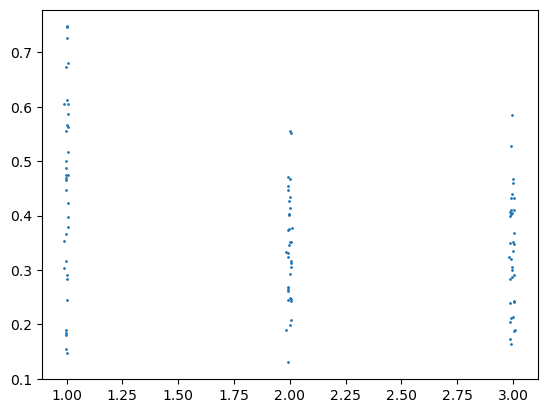

In [16]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [21]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [22]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [23]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [17]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [18]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(105, 3)


In [19]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [20]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [ ]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.33it/s]


Loss: 1576.8532974645495
Average Loss: 0.21577083982820874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.72it/s]


Loss: 654.7794877095148
Average Loss: 0.08959763104946836
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.52it/s]


Loss: 455.4640810540877
Average Loss: 0.062324039553104504
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.14it/s]


Loss: 450.63620816217735
Average Loss: 0.06166341107856833
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.97it/s]


Loss: 450.23149622092023
Average Loss: 0.06160803177626167
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.10it/s]


Loss: 449.5777094261721
Average Loss: 0.061518569981687476
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.17it/s]


Loss: 448.74182574171573
Average Loss: 0.06140419071452049
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.21it/s]


Loss: 448.4176357924007
Average Loss: 0.061359829747181266
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:17<00:00, 93.94it/s]


Loss: 447.546160121914
Average Loss: 0.06124058020277969
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.40it/s]


Loss: 446.752502000425
Average Loss: 0.06113197892726122
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|██▌                                                                                                                                                            | 115/7308 [00:03<01:12, 99.03it/s]

X_batch: 
torch.Size([128, 105])
tensor([[0.1730, 0.0803, 0.0491,  ..., 0.1475, 0.0443, 0.0650],
        [0.5462, 0.4126, 0.3972,  ..., 0.6149, 0.1477, 0.4014],
        [0.6091, 0.1922, 0.3476,  ..., 0.4224, 0.2434, 0.3321],
        ...,
        [0.4036, 0.2941, 0.1466,  ..., 0.3624, 0.2376, 0.2164],
        [0.3727, 0.5325, 0.3027,  ..., 0.6991, 0.2805, 0.6069],
        [0.2349, 0.1240, 0.0999,  ..., 0.1826, 0.1316, 0.1474]])
X_pred: 
torch.Size([128, 105])
tensor([[0.1477, 0.0184, 0.0033,  ..., 0.1242, 0.0419, 0.0151],
        [0.5300, 0.3148, 0.1772,  ..., 0.5281, 0.2634, 0.2745],
        [0.5754, 0.3082, 0.1794,  ..., 0.5091, 0.3672, 0.2793],
        ...,
        [0.4594, 0.2188, 0.1079,  ..., 0.4545, 0.1533, 0.2044],
        [0.5475, 0.3352, 0.1989,  ..., 0.5603, 0.2285, 0.3054],
        [0.2578, 0.0602, 0.0183,  ..., 0.2306, 0.0852, 0.0517]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.36it/s]


Loss: 445.7988926949911
Average Loss: 0.06100149051655598
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.17it/s]


Loss: 446.03319681296125
Average Loss: 0.061033551835380576
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.82it/s]


Loss: 444.3986867032945
Average Loss: 0.060809891448179325
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.31it/s]


Loss: 444.7285720310174
Average Loss: 0.060855031750276053
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.16it/s]


Loss: 444.44757449859753
Average Loss: 0.060816581075341755
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.01it/s]


Loss: 443.2674076342955
Average Loss: 0.06065509135663595
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.19it/s]


Loss: 442.62708578119054
Average Loss: 0.06056747205544479
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.18it/s]


Loss: 442.34139426844195
Average Loss: 0.060528379073404755
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.91it/s]


Loss: 441.819382481277
Average Loss: 0.060456948889063625
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.60it/s]


Loss: 441.4959251508117
Average Loss: 0.06041268817060915
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.42it/s]


Loss: 441.21527592558414
Average Loss: 0.060374285156757544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.07it/s]


Loss: 440.4033321738243
Average Loss: 0.06026318174244996
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.78it/s]


Loss: 440.3291655154899
Average Loss: 0.06025303304809659
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.87it/s]


Loss: 439.71670968737453
Average Loss: 0.060169226831879384
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.93it/s]


Loss: 439.61917239427567
Average Loss: 0.06015588018531413
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.17it/s]


Loss: 438.74699993338436
Average Loss: 0.06003653529466124
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.87it/s]


Loss: 438.81076284637675
Average Loss: 0.06004526037854088
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.15it/s]


Loss: 438.22326882509515
Average Loss: 0.05996486984470377
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.90it/s]


Loss: 437.7508779694326
Average Loss: 0.05990022960720206
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.38it/s]


Loss: 437.5469877808355
Average Loss: 0.05987233001927141
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.31it/s]


Loss: 430.1213680568617
Average Loss: 0.05885623536629197
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.35it/s]


Loss: 421.86329270293936
Average Loss: 0.0577262305285905
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.61it/s]


Loss: 417.7942888659891
Average Loss: 0.0571694429209071
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.79it/s]


Loss: 415.4936354311649
Average Loss: 0.05685462991668923
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.03it/s]


Loss: 415.20103924092837
Average Loss: 0.05681459212382709
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.64it/s]


Loss: 413.75305768381804
Average Loss: 0.056616455621759446
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.84it/s]


Loss: 413.5885495329276
Average Loss: 0.05659394492787734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.81it/s]


Loss: 412.87760203238577
Average Loss: 0.056496661471317156
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.81it/s]


Loss: 412.5821238383651
Average Loss: 0.05645622931559457
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.92it/s]


Loss: 411.8597227472346
Average Loss: 0.05635737859157562
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.28it/s]


Loss: 411.5011363956146
Average Loss: 0.056308310946307415
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.25it/s]


Loss: 411.40124353254214
Average Loss: 0.05629464197215957
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.03it/s]


Loss: 411.09463171777315
Average Loss: 0.056252686332481275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.89it/s]


Loss: 410.6033932073042
Average Loss: 0.05618546705080791
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 121.84it/s]


Loss: 410.4095875942148
Average Loss: 0.05615894739931785
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.34it/s]


Loss: 409.96272066701204
Average Loss: 0.05609779976286426
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.93it/s]


Loss: 409.8326473531779
Average Loss: 0.056080001006181976
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.09it/s]


Loss: 409.58889307128266
Average Loss: 0.056046646561478196
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.67it/s]


Loss: 409.2858755409252
Average Loss: 0.056005182750537105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.97it/s]


Loss: 409.35804990143515
Average Loss: 0.05601505882614055
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.67it/s]


Loss: 409.12822867091745
Average Loss: 0.05598361092924432
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.33it/s]


Loss: 408.79325327742845
Average Loss: 0.055937774121158794
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.94it/s]


Loss: 408.69755094102584
Average Loss: 0.05592467856335876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.20it/s]


Loss: 408.6852538457606
Average Loss: 0.05592299587380413
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.81it/s]


Loss: 408.1906760807615
Average Loss: 0.055855319660750066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.29it/s]


Loss: 408.3314573869575
Average Loss: 0.055874583659955866
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.82it/s]


Loss: 408.29213421233
Average Loss: 0.05586920282051587
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.97it/s]


Loss: 407.92260715714656
Average Loss: 0.055818638089374185
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.81it/s]


Loss: 407.9362770835869
Average Loss: 0.05582050863212738
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.85it/s]


Loss: 407.7565316441469
Average Loss: 0.05579591292339175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.29it/s]


Loss: 407.5152098138351
Average Loss: 0.05576289132646895
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.18it/s]


Loss: 407.55834555835463
Average Loss: 0.0557687938640332
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.66it/s]


Loss: 407.429529359797
Average Loss: 0.055751167126409006
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.19it/s]


Loss: 407.17354572028853
Average Loss: 0.055716139261123225
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.74it/s]


Loss: 407.1028710985556
Average Loss: 0.05570646840429059
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.16it/s]


Loss: 407.2517759730108
Average Loss: 0.055726844002875045
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.82it/s]


Loss: 407.0051432335749
Average Loss: 0.05569309568056581
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.29it/s]


Loss: 406.8577997602988
Average Loss: 0.0556729337384098
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.08it/s]


Loss: 406.74114098749124
Average Loss: 0.05565697057847444
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.01it/s]


Loss: 406.8236460159533
Average Loss: 0.055668260264908766
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.49it/s]


Loss: 406.7570330488961
Average Loss: 0.05565914519005147
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.47it/s]


Loss: 406.6632627688814
Average Loss: 0.05564631400778344
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.48it/s]


Loss: 406.5403757612221
Average Loss: 0.055629498598963066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.17it/s]


Loss: 406.4097210110631
Average Loss: 0.055611620280659975
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.90it/s]


Loss: 406.2091237665154
Average Loss: 0.05558417128715318
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.39it/s]


Loss: 406.39423302328214
Average Loss: 0.05560950096104025
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.79it/s]


Loss: 406.1949221699033
Average Loss: 0.055582227992597606
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.24it/s]


Loss: 406.0889050876722
Average Loss: 0.05556772100269187
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.68it/s]


Loss: 406.05489537562244
Average Loss: 0.05556306723804357
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.60it/s]


Loss: 406.02579996199347
Average Loss: 0.05555908592802319
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.26it/s]


Loss: 405.80653447378427
Average Loss: 0.05552908244030983
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.00it/s]


Loss: 405.83646122762
Average Loss: 0.055533177507884515
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.66it/s]


Loss: 405.8183508729562
Average Loss: 0.055530699353168615
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.32it/s]


Loss: 405.82695934921503
Average Loss: 0.05553187730558498
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.84it/s]


Loss: 405.83832005318254
Average Loss: 0.05553343186277813
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.71it/s]


Loss: 405.5573104096111
Average Loss: 0.05549497953059812
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.82it/s]


Loss: 405.738407677738
Average Loss: 0.055519760218628623
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.47it/s]


Loss: 405.490741225658
Average Loss: 0.0554858704468607
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.78it/s]


Loss: 405.5748607949354
Average Loss: 0.055497381061157
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.21it/s]


Loss: 405.5738300799858
Average Loss: 0.05549724002189187
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.33it/s]


Loss: 405.3174781536218
Average Loss: 0.05546216176157934
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.22it/s]


Loss: 405.2693029367365
Average Loss: 0.055455569641042216
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.73it/s]


Loss: 405.3783768208232
Average Loss: 0.05547049491253738
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.72it/s]


Loss: 405.19191734981723
Average Loss: 0.05544498048027056
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.93it/s]


Loss: 405.204948984785
Average Loss: 0.05544676368155241
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.95it/s]


Loss: 405.14181146910414
Average Loss: 0.05543812417475426
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.73it/s]


Loss: 404.89275123900734
Average Loss: 0.05540404368349854
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.64it/s]


Loss: 405.0351174150128
Average Loss: 0.05542352455049436
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.81it/s]


Loss: 404.9922933469061
Average Loss: 0.05541766466159087
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.10it/s]


Loss: 404.9006339793559
Average Loss: 0.055405122328866435
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.77it/s]


Loss: 404.82737068622373
Average Loss: 0.055395097247704396
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.42it/s]


Loss: 404.7494709016755
Average Loss: 0.05538443772600924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.05it/s]


Loss: 404.9478457146324
Average Loss: 0.05541158261010296
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.26it/s]


Loss: 404.68634438863955
Average Loss: 0.055375799724772794
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.23it/s]


Loss: 404.6148356110789
Average Loss: 0.05536601472510658
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.32it/s]


Loss: 404.65450276853517
Average Loss: 0.055371442633899176
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.24it/s]


Loss: 404.57464725291356
Average Loss: 0.05536051549711461
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.98it/s]


Loss: 404.61986082349904
Average Loss: 0.055366702356800634
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.44it/s]


Loss: 404.63633439014666
Average Loss: 0.055368956539428936
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.74it/s]


Loss: 404.5411892856937
Average Loss: 0.05535593723121151
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.80it/s]


Loss: 404.43121476564556
Average Loss: 0.05534088871998434
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.87it/s]


Loss: 404.4176749298349
Average Loss: 0.055339035978357265
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.04it/s]


Loss: 404.46480995067395
Average Loss: 0.055345485762270656
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.38it/s]


Loss: 404.4011769129429
Average Loss: 0.05533677845004692
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.46it/s]


Loss: 404.3639723584056
Average Loss: 0.055331687514833826
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.71it/s]


Loss: 404.5471389067825
Average Loss: 0.05535675135560789
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.16it/s]


Loss: 404.3222193631809
Average Loss: 0.055325974187627386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.47it/s]


Loss: 404.2705309547018
Average Loss: 0.055318901334797735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.60it/s]


Loss: 404.2924484740943
Average Loss: 0.05532190044801509
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.29it/s]


Loss: 404.3414729775395
Average Loss: 0.05532860878181986
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.88it/s]


Loss: 404.22436327813193
Average Loss: 0.055312583918737265
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.20it/s]


Loss: 404.2804810537491
Average Loss: 0.05532026286997114
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.88it/s]


Loss: 404.0801832380239
Average Loss: 0.05529285484920962
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.54it/s]


Loss: 404.1332056915853
Average Loss: 0.055300110247890714
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.53it/s]


Loss: 404.2323979153298
Average Loss: 0.05531368334911464
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.86it/s]


Loss: 404.0213309926912
Average Loss: 0.05528480172313782
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.68it/s]


Loss: 404.0795059350785
Average Loss: 0.05529276216955097
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.17it/s]


Loss: 403.95208257390186
Average Loss: 0.0552753260227014
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.19it/s]


Loss: 403.9646576163359
Average Loss: 0.05527704674553036
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.55it/s]


Loss: 404.0629985695705
Average Loss: 0.05529050336201019
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.27it/s]


Loss: 403.9568458243739
Average Loss: 0.05527597780848028
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.52it/s]


Loss: 403.95372768095694
Average Loss: 0.05527555113313587
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.00it/s]


Loss: 403.9935716642067
Average Loss: 0.05528100323812352
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.52it/s]


Loss: 403.95027160132304
Average Loss: 0.05527507821583512
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.55it/s]


Loss: 403.78100232896395
Average Loss: 0.055251916027499175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.00it/s]


Loss: 403.77846294105984
Average Loss: 0.055251568546943054
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.41it/s]


Loss: 403.8844554736279
Average Loss: 0.05526607217756266
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.08it/s]


Loss: 403.8190909209661
Average Loss: 0.05525712793116668
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.68it/s]


Loss: 403.7306867823936
Average Loss: 0.055245031032073566
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.77it/s]


Loss: 403.7840933436528
Average Loss: 0.05525233899064762
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.56it/s]


Loss: 403.6657335367054
Average Loss: 0.05523614306742
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 123.89it/s]


Loss: 403.69956769794226
Average Loss: 0.05524077281033692
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.85it/s]


Loss: 403.72559233685024
Average Loss: 0.05524433392677206
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.00it/s]


Loss: 403.84004562022164
Average Loss: 0.05525999529559683
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.27it/s]


Loss: 403.76306226174347
Average Loss: 0.0552494611742944
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.99it/s]


Loss: 403.6767951606307
Average Loss: 0.05523765669959369
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.46it/s]


Loss: 403.54496388719417
Average Loss: 0.05521961739014698
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.53it/s]


Loss: 403.55318267806433
Average Loss: 0.055220742019439564
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.60it/s]


Loss: 403.5539903221652
Average Loss: 0.055220852534505364
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.03it/s]


Loss: 403.6249089394696
Average Loss: 0.05523055677879989
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.39it/s]


Loss: 403.46642121998593
Average Loss: 0.05520886989873918
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.20it/s]


Loss: 403.5410860220436
Average Loss: 0.05521908675725829
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.47it/s]


Loss: 403.5990219214
Average Loss: 0.055227014493897095
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.69it/s]


Loss: 403.5227057370357
Average Loss: 0.055216571666261045
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.01it/s]


Loss: 403.40440141852014
Average Loss: 0.05520038333586756
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.43it/s]


Loss: 403.38870238582604
Average Loss: 0.055198235137633556
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.30it/s]


Loss: 403.47015806497075
Average Loss: 0.055209381234944
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.31it/s]


Loss: 403.4347329265438
Average Loss: 0.055204533788525426
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.64it/s]


Loss: 403.4031139924191
Average Loss: 0.05520020716918707
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.95it/s]


Loss: 403.38401762372814
Average Loss: 0.055197594091916824
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.07it/s]


Loss: 403.421153195668
Average Loss: 0.05520267558780351
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.28it/s]


Loss: 403.3673656359315
Average Loss: 0.05519531549479084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.40it/s]


Loss: 403.3440918540582
Average Loss: 0.055192130795574466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.75it/s]


Loss: 403.2899393902626
Average Loss: 0.05518472077042455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.38it/s]


Loss: 403.2897196931299
Average Loss: 0.05518469070787218
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 0


 35%|███████████████████████████████████████████████████████▍                                                                                                     | 2583/7308 [00:17<00:27, 173.99it/s]

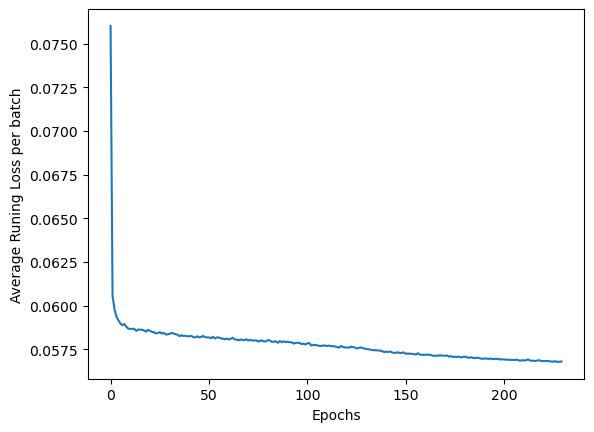

In [28]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

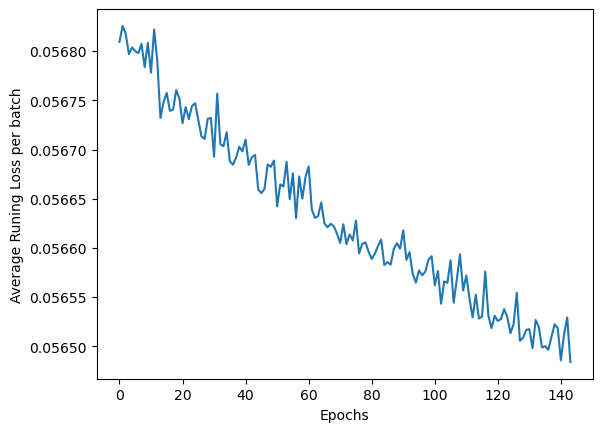

In [30]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [80]:
torch.save(final_model, 'model_100206_9groups_01.pt')